In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import keras as krs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from scipy.stats import skew, kurtosis
from scipy.optimize import differential_evolution, minimize
from scipy.fft import fft
from scipy.interpolate import interp1d

In [2]:
data = pd.read_csv('multi_sensor_simulated_sound_data.csv')

In [3]:
# Separate the data by sensor
sensor1_data = data[data['Sensor'] == 'Sensor1']
sensor2_data = data[data['Sensor'] == 'Sensor2']
sensor3_data = data[data['Sensor'] == 'Sensor3']
sensor4_data = data[data['Sensor'] == 'Sensor4']

# Combine data for all sensors into a single DataFrame with separate columns for each sensor's amplitude
combined_data = pd.DataFrame({
    'Angle': sensor1_data['Angle'].reset_index(drop=True),  # Use Angle as the reference
    'Sensor1_Amplitude': sensor1_data['Amplitude'].reset_index(drop=True),
    'Sensor2_Amplitude': sensor2_data['Amplitude'].reset_index(drop=True),
    'Sensor3_Amplitude': sensor3_data['Amplitude'].reset_index(drop=True),
    'Sensor4_Amplitude': sensor4_data['Amplitude'].reset_index(drop=True)
})

In [4]:
# Function to calculate THD
def calculate_thd(signal):
    fft_spectrum = np.abs(fft(signal))
    fundamental = fft_spectrum[1]  # Assuming the fundamental is at index 1
    harmonics = np.sum(fft_spectrum[2:])  # Sum of all higher-order harmonics
    thd = harmonics / fundamental if fundamental != 0 else 0
    return thd

# Function to calculate SNR
def calculate_snr(signal, noise_level=1e-10):
    signal_power = np.mean(np.square(signal))
    noise_power = noise_level
    snr = 10 * np.log10(signal_power / noise_power) if noise_power != 0 else 0
    return snr

# Function to calculate SPL
def calculate_spl(signal, reference_pressure=20e-6):
    rms = np.sqrt(np.mean(np.square(signal)))
    spl = 20 * np.log10(rms / reference_pressure) if reference_pressure != 0 else 0
    return spl

# Function to extract features from a signal
def extract_features(signal):
    # Time-domain features
    mean = np.mean(signal)
    variance = np.var(signal)
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    crest_factor = np.max(np.abs(signal)) / np.sqrt(np.mean(np.square(signal))) if np.mean(np.square(signal)) > 0 else 0
    dynamic_range = np.max(signal) - np.min(signal)
    
    # Frequency-domain features
    fft_spectrum = np.abs(fft(signal))
    dominant_freq = np.argmax(fft_spectrum[:len(fft_spectrum)//2])  # Dominant frequency
    spectral_flatness = np.exp(np.mean(np.log(fft_spectrum + 1e-10))) / np.mean(fft_spectrum + 1e-10)
    
    # Audio metrics
    thd = calculate_thd(signal)
    snr = calculate_snr(signal)
    spl = calculate_spl(signal)
    
    return [
        mean, variance, std_dev, skewness, kurt,
        crest_factor, dynamic_range, dominant_freq, spectral_flatness,
        thd, snr, spl
    ]

# Function to extract features with sliding 1 ms windows
def extract_features_with_1ms_window(signal, window_size=44, step_size=44):
    features = []
    for start in range(0, len(signal) - window_size + 1, step_size):
        window = signal[start:start + window_size]
        features.append(extract_features(window))
    return features

In [5]:
# Separate the data by sensor
sensor1_data = data[data['Sensor'] == 'Sensor1']
sensor2_data = data[data['Sensor'] == 'Sensor2']
sensor3_data = data[data['Sensor'] == 'Sensor3']
sensor4_data = data[data['Sensor'] == 'Sensor4']

# Combine data for all sensors into a single DataFrame with separate columns for each sensor's amplitude
combined_data = pd.DataFrame({
    'Angle': sensor1_data['Angle'].reset_index(drop=True),  # Use Angle as the reference
    'Sensor1_Amplitude': sensor1_data['Amplitude'].reset_index(drop=True),
    'Sensor2_Amplitude': sensor2_data['Amplitude'].reset_index(drop=True),
    'Sensor3_Amplitude': sensor3_data['Amplitude'].reset_index(drop=True),
    'Sensor4_Amplitude': sensor4_data['Amplitude'].reset_index(drop=True)
})

In [6]:
combined_data
csv_data = combined_data.to_csv('combined_data.csv', index=False)
combined_data.shape

(1543500, 5)

In [7]:
# Load combined_data
combined_data = pd.read_csv('combined_data.csv')

# Placeholder for segmented feature data
segmented_feature_data_1ms = []

# Process each angle
for angle in combined_data['Angle'].unique():
    # Filter rows corresponding to the current angle
    angle_data = combined_data[combined_data['Angle'] == angle]
    
    # Extract full signals for each sensor
    sensor1_signal = angle_data['Sensor1_Amplitude'].values
    sensor2_signal = angle_data['Sensor2_Amplitude'].values
    sensor3_signal = angle_data['Sensor3_Amplitude'].values
    sensor4_signal = angle_data['Sensor4_Amplitude'].values

    # Perform windowed feature extraction for each sensor
    sensor1_features = extract_features_with_1ms_window(sensor1_signal)
    sensor2_features = extract_features_with_1ms_window(sensor2_signal)
    sensor3_features = extract_features_with_1ms_window(sensor3_signal)
    sensor4_features = extract_features_with_1ms_window(sensor4_signal)
    
    # Combine features for all sensors, keeping the angle as the label
    for i in range(len(sensor1_features)):
        combined_features = (
            sensor1_features[i] +
            sensor2_features[i] +
            sensor3_features[i] +
            sensor4_features[i] +
            [angle]
        )
        segmented_feature_data_1ms.append(combined_features)

columns_1ms = (
    [f"Sensor1_{feat}" for feat in [
        'Mean', 'Variance', 'StdDev', 'Skewness', 'Kurtosis', 
        'CrestFactor', 'DynamicRange', 'DominantFreq', 'SpectralFlatness',
        'THD', 'SNR', 'SPL'
    ]] +
    [f"Sensor2_{feat}" for feat in [
        'Mean', 'Variance', 'StdDev', 'Skewness', 'Kurtosis', 
        'CrestFactor', 'DynamicRange', 'DominantFreq', 'SpectralFlatness',
        'THD', 'SNR', 'SPL'
    ]] +
    [f"Sensor3_{feat}" for feat in [
        'Mean', 'Variance', 'StdDev', 'Skewness', 'Kurtosis', 
        'CrestFactor', 'DynamicRange', 'DominantFreq', 'SpectralFlatness',
        'THD', 'SNR', 'SPL'
    ]] +
    [f"Sensor4_{feat}" for feat in [
        'Mean', 'Variance', 'StdDev', 'Skewness', 'Kurtosis', 
        'CrestFactor', 'DynamicRange', 'DominantFreq', 'SpectralFlatness',
        'THD', 'SNR', 'SPL'
    ]] +
    ['Angle']
)

# Create a DataFrame from the segmented features
segmented_feature_df_1ms = pd.DataFrame(segmented_feature_data_1ms, columns=columns_1ms)

segmented_feature_df_1ms
feature_data = segmented_feature_df_1ms
feature_data.shape
feature_data.to_csv('feature_data.csv', index=False)

In [2]:
feature_data = pd.read_csv('feature_data.csv')
feature_data

,Sensor1_Mean,Sensor1_Variance,Sensor1_StdDev,Sensor1_Skewness,Sensor1_Kurtosis,Sensor1_CrestFactor,Sensor1_DynamicRange,Sensor1_DominantFreq,Sensor1_SpectralFlatness,Sensor1_THD,...,Sensor4_Skewness,Sensor4_Kurtosis,Sensor4_CrestFactor,Sensor4_DynamicRange,Sensor4_DominantFreq,Sensor4_SpectralFlatness,Sensor4_THD,Sensor4_SNR,Sensor4_SPL,Angle
0,22.916604,0.189128,0.434888,-0.043250,-0.985135,1.029344,1.560824,0,0.039116,4.678676,...,0.241506,-0.573108,1.034090,3.836430,0,0.044358,4.002310,132.837570,126.816970,-90
1,22.115065,1.082562,1.040463,0.150727,-1.202175,1.078760,3.400281,0,0.073266,4.004191,...,0.154290,-1.724536,1.031162,2.574860,0,0.055473,4.726039,132.411441,126.390841,-90
2,22.897136,0.142579,0.377596,0.573618,-0.637084,1.037283,1.364838,0,0.029895,5.414831,...,-0.111280,-0.982675,1.031868,2.508316,0,0.016791,2.769499,132.389377,126.368777,-90
3,25.384261,8.483320,2.912614,0.770975,-0.785205,1.231356,9.153528,0,0.240340,5.833490,...,0.445557,-1.045067,1.013310,1.265053,0,0.016568,8.229887,132.135685,126.115086,-90
4,37.071854,11.116756,3.334180,0.107236,-1.185615,1.152274,11.023384,0,0.226133,6.756456,...,0.470662,-1.324249,1.054050,6.002784,0,0.121156,5.337019,132.951057,126.930457,-90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35072,-18.071807,0.930834,0.964797,-0.560016,-0.461844,1.131529,3.806254,0,0.132827,4.664318,...,-0.333423,-1.329982,1.305647,9.814831,0,0.326081,5.741055,125.447360,119.426760,90
35073,-14.689087,4.046966,2.011707,-0.063893,-1.588994,1.188049,5.956837,0,0.274667,5.419607,...,-0.044274,-1.529806,1.237070,5.590709,0,0.310807,5.726770,121.338031,115.317431,90
35074,-8.786245,1.932959,1.390309,-0.395691,-0.890966,1.315315,4.948211,0,0.219962,3.829124,...,0.162129,-1.436258,1.707778,14.287495,1,0.662847,5.846180,114.258395,108.237795,90
35075,-10.260229,0.361248,0.601040,0.802551,-0.169879,1.086968,2.222180,0,0.124288,9.536536,...,-0.128416,-1.362827,1.328323,10.537545,0,0.425637,6.057947,121.737209,115.716609,90


In [9]:
# Define all features to interpolate
features = feature_data.columns.difference(['Angle'])  # All columns except 'Angle'

# Define existing and new angles
existing_angles = [-90, -60, -30, 0, 30, 60, 90]
new_angles = np.arange(-90, 91, 5)  # All angles with step of 5 degrees

# Placeholder for all interpolated data
all_interpolated_data = []

# Loop through each feature
for feature in features:
    # Extract rows for each existing angle
    angle_grouped_data = {
        angle: feature_data[feature_data['Angle'] == angle][feature].values
        for angle in existing_angles
    }

    # Get the number of rows for interpolation
    rows_per_angle = min(len(angle_grouped_data[angle]) for angle in existing_angles)

    # Interpolate for each row
    for row_idx in range(rows_per_angle):
        # Extract row values for each angle
        row_values = [angle_grouped_data[angle][row_idx] for angle in existing_angles]

        # Create interpolation function
        interp_func = interp1d(
            existing_angles, row_values, kind='cubic', fill_value="extrapolate"
        )

        # Interpolate for new angles
        interpolated_values = interp_func(new_angles)

        # Append the interpolated values for each feature
        for angle, value in zip(new_angles, interpolated_values):
            all_interpolated_data.append({
                'Angle': angle,
                'Row_Index': row_idx,
                feature: value
            })

# Convert all interpolated data to DataFrame
interpolated_all_features_df = pd.DataFrame(all_interpolated_data)

# Merge interpolated data for all features
final_interpolated_df = interpolated_all_features_df.pivot_table(
    index=['Angle', 'Row_Index'], aggfunc='first'
).reset_index()



# Sort by Angle and Row_Index
final_interpolated_df = final_interpolated_df.sort_values(by=['Angle', 'Row_Index']).reset_index(drop=True)

In [10]:
# metrics and sensor_columns definitions
metrics = ['SPL', 'SNR', 'THD', 'SpectralFlatness']
sensor_columns = {metric: [f"Sensor{i}_{metric}" for i in range(1, 5)] for metric in metrics}

# Calculate variances
variances = {}
for metric, columns in sensor_columns.items():
    variances[metric] = final_interpolated_df[columns].var(axis=1)

# Normalize the variances with separate scalers
scalers_variances = {metric: MinMaxScaler() for metric in metrics}
normalized_variances = {}
for metric in metrics:
    normalized_variances[metric] = scalers_variances[metric].fit_transform(variances[metric].values.reshape(-1, 1)).flatten()

# Calculate equality_sound as a weighted sum of normalized variances
weights_equality = {'SPL': 1, 'SNR': 1, 'THD': 1, 'SpectralFlatness': 1}
final_interpolated_df['equality_sound'] = sum(weights_equality[metric] * normalized_variances[metric] for metric in metrics)

# Normalize the metrics with separate scalers
scalers_metrics = {metric: MinMaxScaler() for metric in metrics}
normalized_metrics = {}
for metric, columns in sensor_columns.items():
    normalized_metrics[metric] = scalers_metrics[metric].fit_transform(final_interpolated_df[columns])

normalized_df = pd.DataFrame({f"{metric}_sensor{i+1}": normalized_metrics[metric][:, i] for metric in metrics for i in range(4)})

# Calculate score_sound as a weighted sum of the normalized metrics themselves
scores = {}
for metric, columns in sensor_columns.items():
    scores[metric] = normalized_df[[f"{metric}_sensor{i+1}" for i in range(4)]].mean(axis=1)

weights_score = {'SPL': 1, 'SNR': 1, 'THD': -1, 'SpectralFlatness': 1}
final_interpolated_df['score_sound'] = sum(weights_score[metric] * scores[metric] for metric in metrics)

# Inverse transform the features with separate scalers
scaler_equality_sound = MinMaxScaler()
scaler_score_sound = MinMaxScaler()

# Fit the scalers on the original equality_sound and score_sound before normalization
scaler_equality_sound.fit(final_interpolated_df[['equality_sound']])
scaler_score_sound.fit(final_interpolated_df[['score_sound']])

# Inverse transform the features
final_interpolated_df['equality_sound'] = scaler_equality_sound.inverse_transform(final_interpolated_df[['equality_sound']])
final_interpolated_df['score_sound'] = scaler_score_sound.inverse_transform(final_interpolated_df[['score_sound']])

final_interpolated_df

,Angle,Row_Index,Sensor1_CrestFactor,Sensor1_DominantFreq,Sensor1_DynamicRange,Sensor1_Kurtosis,Sensor1_Mean,Sensor1_SNR,Sensor1_SPL,Sensor1_Skewness,...,Sensor4_Mean,Sensor4_SNR,Sensor4_SPL,Sensor4_Skewness,Sensor4_SpectralFlatness,Sensor4_StdDev,Sensor4_THD,Sensor4_Variance,equality_sound,score_sound
0,-90,0,1.029344,0.0,1.560824,-0.985135,22.916604,127.204569,121.183969,-0.043250,...,-43.829639,132.837570,126.816970,0.241506,0.044358,0.989274,4.002310,0.978663,0.485179,2.240457
1,-90,1,1.078760,0.0,3.400281,-1.202175,22.115065,126.903367,120.882767,0.150727,...,-41.732698,132.411441,126.390841,0.154290,0.055473,0.875646,4.726039,0.766755,0.471107,2.121409
2,-90,2,1.037283,0.0,1.364838,-0.637084,22.897136,127.196804,121.176204,0.573618,...,-41.629446,132.389377,126.368777,-0.111280,0.016791,0.737985,2.769499,0.544621,1.517615,2.128222
3,-90,3,1.231356,0.0,9.153528,-0.785205,25.384261,128.148094,122.127494,0.770975,...,-40.436044,132.135685,126.115086,0.445557,0.016568,0.342890,8.229887,0.117573,0.418101,2.370371
4,-90,4,1.152274,0.0,11.023384,-1.185615,37.071854,131.415874,125.395275,0.107236,...,-44.361937,132.951057,126.930457,0.470662,0.121156,2.218443,5.337019,4.921489,0.199115,2.443685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185402,90,5006,1.131529,0.0,3.806254,-0.461844,-18.071807,125.152392,119.131792,-0.560016,...,-18.452449,125.447360,119.426760,-0.333423,0.326081,3.169516,5.741055,10.045833,0.845627,2.864955
185403,90,5007,1.188049,0.0,5.956837,-1.588994,-14.689087,123.420598,117.399998,-0.063893,...,-11.530929,121.338031,115.317431,-0.044274,0.310807,1.766476,5.726770,3.120436,1.058544,2.954743
185404,90,5008,1.315315,0.0,4.948211,-0.890966,-8.786245,118.983470,112.962870,-0.395691,...,-2.149261,114.258395,108.237795,0.162129,0.662847,4.694615,5.846180,22.039410,1.603567,2.897098
185405,90,5009,1.086968,0.0,2.222180,-0.169879,-10.260229,120.238019,114.217419,0.802551,...,11.755232,121.737209,115.716609,-0.128416,0.425637,3.316330,6.057947,10.998048,1.107221,2.846041


In [11]:
final_interpolated_df = final_interpolated_df.drop(columns=['Row_Index'])

In [12]:
# Save the updated DataFrame if needed
final_interpolated_df.to_csv('final_interpolated_data.csv', index=False)

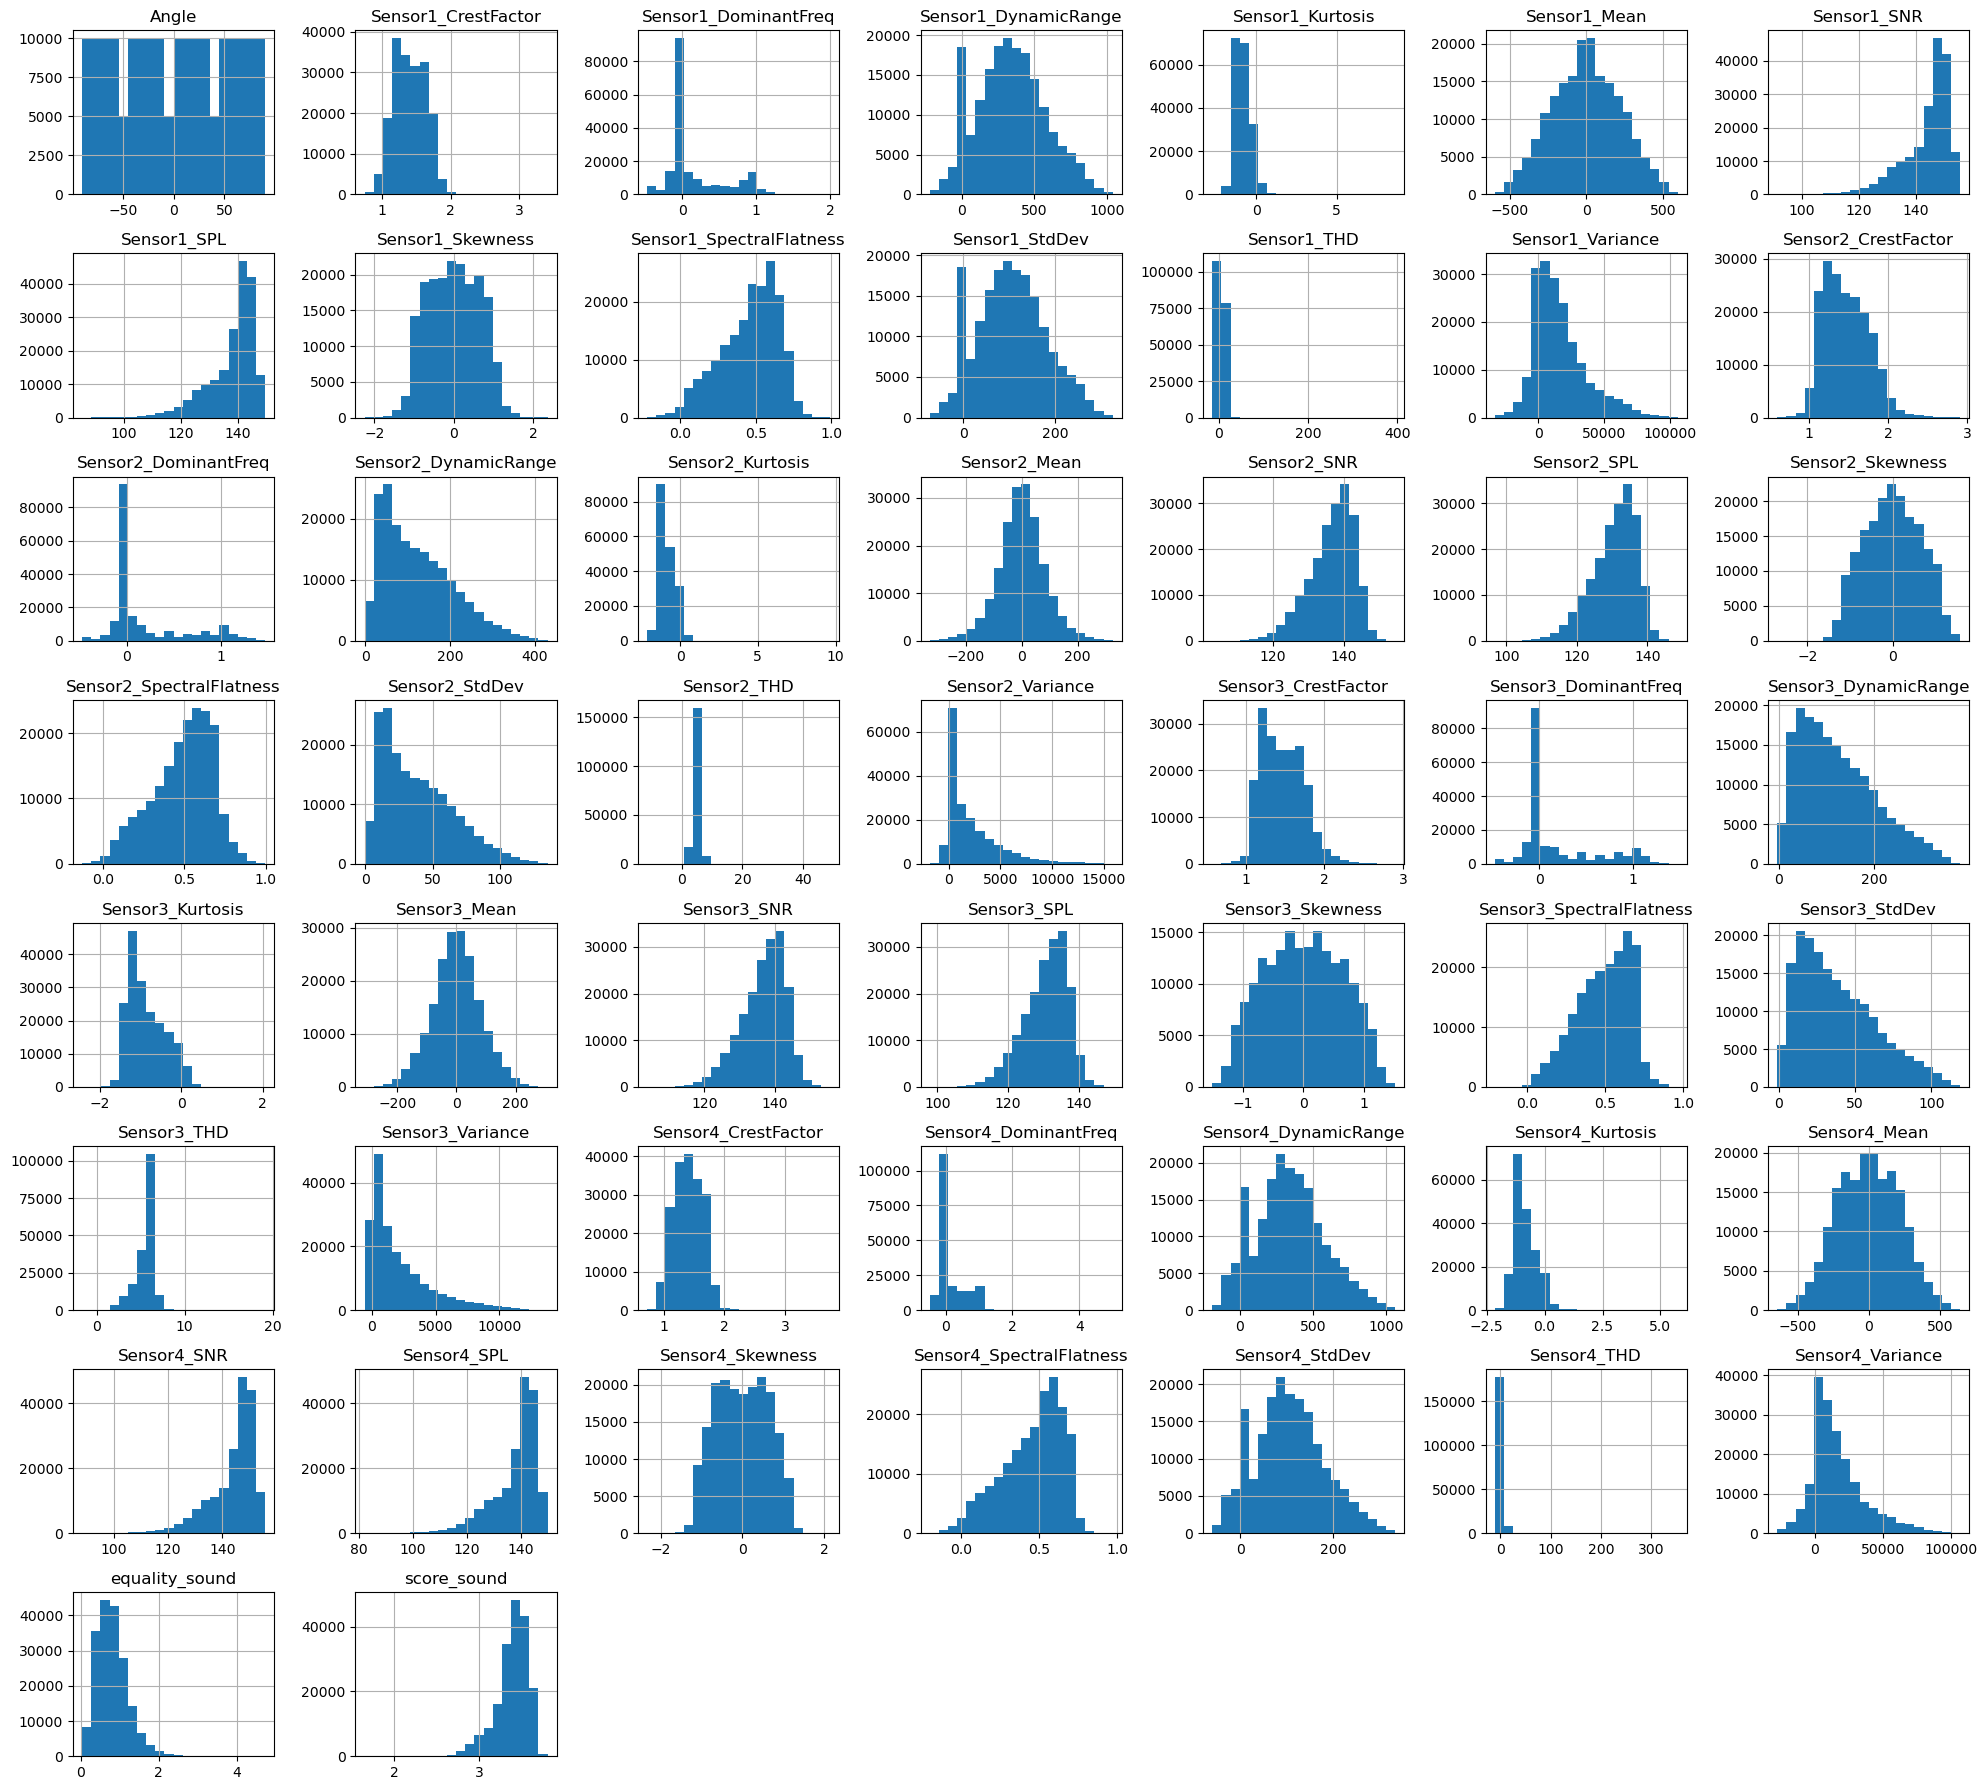

In [13]:
final_interpolated_df.hist(bins=20, figsize=(20, 18))
plt.tight_layout()
plt.show()

In [4]:
final_interpolated_df = pd.read_csv('final_interpolated_data.csv')

In [5]:
final_interpolated_df.columns

Index(['Angle', 'Sensor1_CrestFactor', 'Sensor1_DominantFreq',
       'Sensor1_DynamicRange', 'Sensor1_Kurtosis', 'Sensor1_Mean',
       'Sensor1_SNR', 'Sensor1_SPL', 'Sensor1_Skewness',
       'Sensor1_SpectralFlatness', 'Sensor1_StdDev', 'Sensor1_THD',
       'Sensor1_Variance', 'Sensor2_CrestFactor', 'Sensor2_DominantFreq',
       'Sensor2_DynamicRange', 'Sensor2_Kurtosis', 'Sensor2_Mean',
       'Sensor2_SNR', 'Sensor2_SPL', 'Sensor2_Skewness',
       'Sensor2_SpectralFlatness', 'Sensor2_StdDev', 'Sensor2_THD',
       'Sensor2_Variance', 'Sensor3_CrestFactor', 'Sensor3_DominantFreq',
       'Sensor3_DynamicRange', 'Sensor3_Kurtosis', 'Sensor3_Mean',
       'Sensor3_SNR', 'Sensor3_SPL', 'Sensor3_Skewness',
       'Sensor3_SpectralFlatness', 'Sensor3_StdDev', 'Sensor3_THD',
       'Sensor3_Variance', 'Sensor4_CrestFactor', 'Sensor4_DominantFreq',
       'Sensor4_DynamicRange', 'Sensor4_Kurtosis', 'Sensor4_Mean',
       'Sensor4_SNR', 'Sensor4_SPL', 'Sensor4_Skewness',
       'Sensor4

In [15]:
# Separate features (X) and target (y)
X = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values  # Drop 'Angle' to get the input features
y = final_interpolated_df[['Angle', 'score_sound', 'equality_sound']].values  # Target values (angles)

# Display the shapes of X and y
print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

Shape of X (features): (185407, 48)
Shape of y (target): (185407, 3)


In [16]:
# Normalize features
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
X_norm = input_scaler.fit_transform(X)
y_norm = output_scaler.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

def weighted_mse(y_true, y_pred):
    weights = 1 + 0.1 * K.abs(y_true)  # Add more weight to extreme angles
    return K.mean(weights * K.square(y_true - y_pred))

In [17]:
# Build the improved DNN model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256), BatchNormalization(), LeakyReLU(alpha=0.01), Dropout(0.3),
    Dense(128), BatchNormalization(), LeakyReLU(alpha=0.01), Dropout(0.3),
    Dense(64), BatchNormalization(), LeakyReLU(alpha=0.01), Dropout(0.2),
    Dense(32), LeakyReLU(alpha=0.01),
    Dense(3, activation='linear')  # Adjust the output layer to have 3 outputs
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Add callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    min_delta=0.001,         # Minimum improvement threshold
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # Reduce learning rate by a factor of 0.5
    patience=5,             # Wait 5 epochs before reducing the learning rate
    min_lr=1e-6,             # Minimum learning rate
    verbose=1
)

# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=300,  # Increased epochs to allow learning rate adjustments
    batch_size=64,  # Smaller batch size for better generalization
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/300
1623/1623 [==============================] - 21s 11ms/step - loss: 0.0372 - mae: 0.1229 - val_loss: 0.0057 - val_mae: 0.0467 - lr: 0.0010
Epoch 2/300
1623/1623 [==============================] - 19s 12ms/step - loss: 0.0080 - mae: 0.0574 - val_loss: 0.0033 - val_mae: 0.0315 - lr: 0.0010
Epoch 3/300
1623/1623 [==============================] - 20s 13ms/step - loss: 0.0053 - mae: 0.0449 - val_loss: 0.0031 - val_mae: 0.0263 - lr: 0.0010
Epoch 4/300
1623/1623 [==============================] - 18s 11ms/step - loss: 0.0043 - mae: 0.0392 - val_loss: 0.0023 - val_mae: 0.0249 - lr: 0.0010
Epoch 5/300
1623/1623 [==============================] - 19s 12ms/step - loss: 0.0037 - mae: 0.0357 - val_loss: 0.0020 - val_mae: 0.0226 - lr: 0.0010
Epoch 6/300
1623/1623 [==============================] - 18s 11ms/step - loss: 0.0032 - mae: 0.0328 - val_loss: 0.0018 - val_mae: 0.0212 - lr: 0.0010
Epoch 7/300
1623/1623 [==============================] - 18s 11ms/step - loss: 0.0029 - mae: 0.0310 

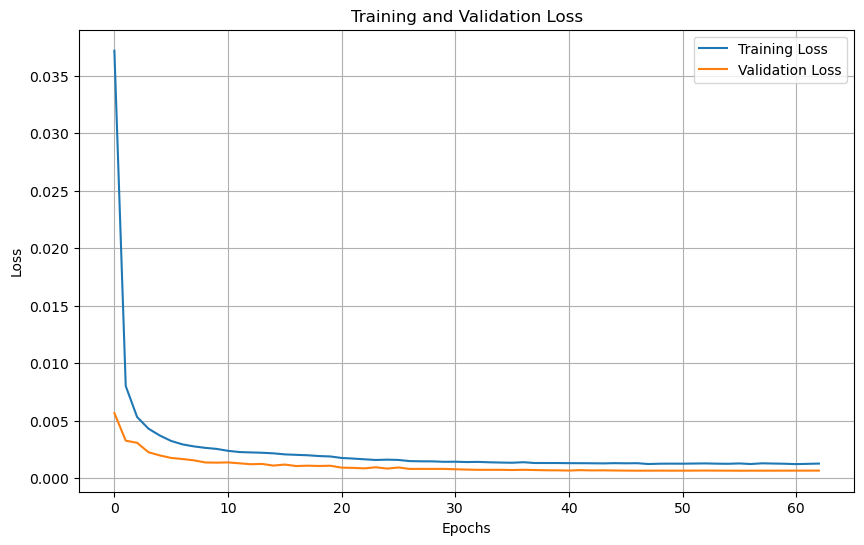

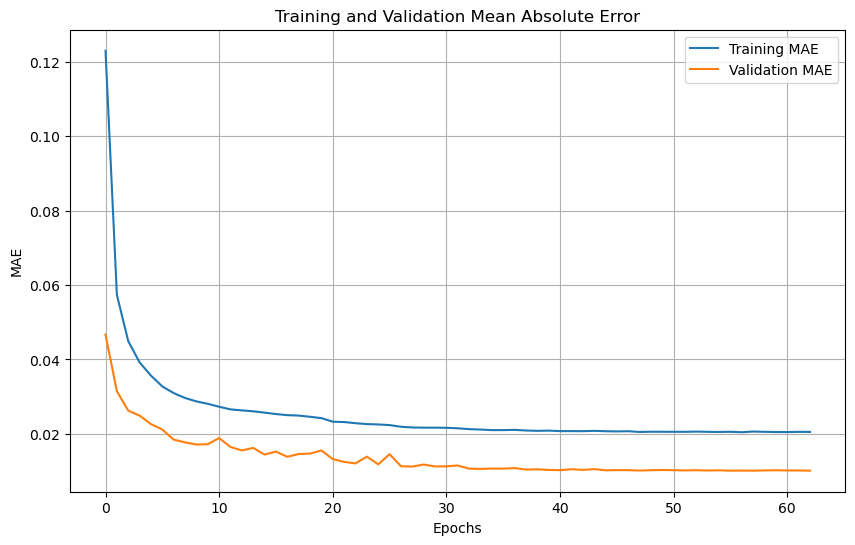

In [18]:
# Save the training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss.png')
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_mae.png')
plt.show()

In [19]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Mean Absolute Error (MAE): {mae}, {loss}")

# Make predictions
y_pred = model.predict(X_test)
y_pred = output_scaler.inverse_transform(y_pred)

Test Mean Absolute Error (MAE): 0.015603765845298767, 0.001243852311745286
1159/1159 [==============================] - 3s 2ms/step


In [20]:
y_test = output_scaler.inverse_transform(y_test)
y_test

array([[ 20.        ,   3.44812528,   1.06090019],
       [ 55.        ,   3.61573642,   0.646283  ],
       [-30.        ,   3.52892423,   0.92650283],
       ...,
       [-70.        ,   3.50329495,   0.26265982],
       [-75.        ,   3.43555742,   1.13717209],
       [-90.        ,   2.74652073,   2.09698152]])

In [21]:
import json

# Calculate evaluation metrics on the original scale for each output
mae_angle = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mse_angle = mean_squared_error(y_test[:, 0], y_pred[:, 0])
rmse_angle = np.sqrt(mse_angle)
r2_angle = r2_score(y_test[:, 0], y_pred[:, 0]) * 100

mae_score_sound = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mse_score_sound = mean_squared_error(y_test[:, 1], y_pred[:, 1])
rmse_score_sound = np.sqrt(mse_score_sound)
r2_score_sound = r2_score(y_test[:, 1], y_pred[:, 1]) * 100

mae_equality_sound = mean_absolute_error(y_test[:, 2], y_pred[:, 2])
mse_equality_sound = mean_squared_error(y_test[:, 2], y_pred[:, 2])
rmse_equality_sound = np.sqrt(mse_equality_sound)
r2_equality_sound = r2_score(y_test[:, 2], y_pred[:, 2]) * 100

# Print the metrics
print(f"Angle - Mean Absolute Error (MAE): {mae_angle}")
print(f"Angle - Mean Squared Error (MSE): {mse_angle}")
print(f"Angle - Root Mean Squared Error (RMSE): {rmse_angle}")
print(f"Angle - R-squared (R²): {r2_angle}%")

print(f"Score Sound - Mean Absolute Error (MAE): {mae_score_sound}")
print(f"Score Sound - Mean Squared Error (MSE): {mse_score_sound}")
print(f"Score Sound - Root Mean Squared Error (RMSE): {rmse_score_sound}")
print(f"Score Sound - R-squared (R²): {r2_score_sound}%")

print(f"Equality Sound - Mean Absolute Error (MAE): {mae_equality_sound}")
print(f"Equality Sound - Mean Squared Error (MSE): {mse_equality_sound}")
print(f"Equality Sound - Root Mean Squared Error (RMSE): {rmse_equality_sound}")
print(f"Equality Sound - R-squared (R²): {r2_equality_sound}%")

# Save the metrics to a dictionary
metrics = {
    'Angle': {
        'MAE': mae_angle,
        'MSE': mse_angle,
        'RMSE': rmse_angle,
        'R2': r2_angle
    },
    'Score_Sound': {
        'MAE': mae_score_sound,
        'MSE': mse_score_sound,
        'RMSE': rmse_score_sound,
        'R2': r2_score_sound
    },
    'Equality_Sound': {
        'MAE': mae_equality_sound,
        'MSE': mse_equality_sound,
        'RMSE': rmse_equality_sound,
        'R2': r2_equality_sound
    }
}

# Save the metrics to a JSON file
with open('evaluation_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

Angle - Mean Absolute Error (MAE): 3.3866664514779004
Angle - Mean Squared Error (MSE): 96.38736939786224
Angle - Root Mean Squared Error (RMSE): 9.817706931756634
Angle - R-squared (R²): 96.63022911933072%
Score Sound - Mean Absolute Error (MAE): 0.02222022331594
Score Sound - Mean Squared Error (MSE): 0.0008437113863687546
Score Sound - Root Mean Squared Error (RMSE): 0.029046710422503175
Score Sound - R-squared (R²): 97.70496603190256%
Equality Sound - Mean Absolute Error (MAE): 0.08278425273900032
Equality Sound - Mean Squared Error (MSE): 0.012614793833638354
Equality Sound - Root Mean Squared Error (RMSE): 0.11231559924444313
Equality Sound - R-squared (R²): 91.8889032417167%


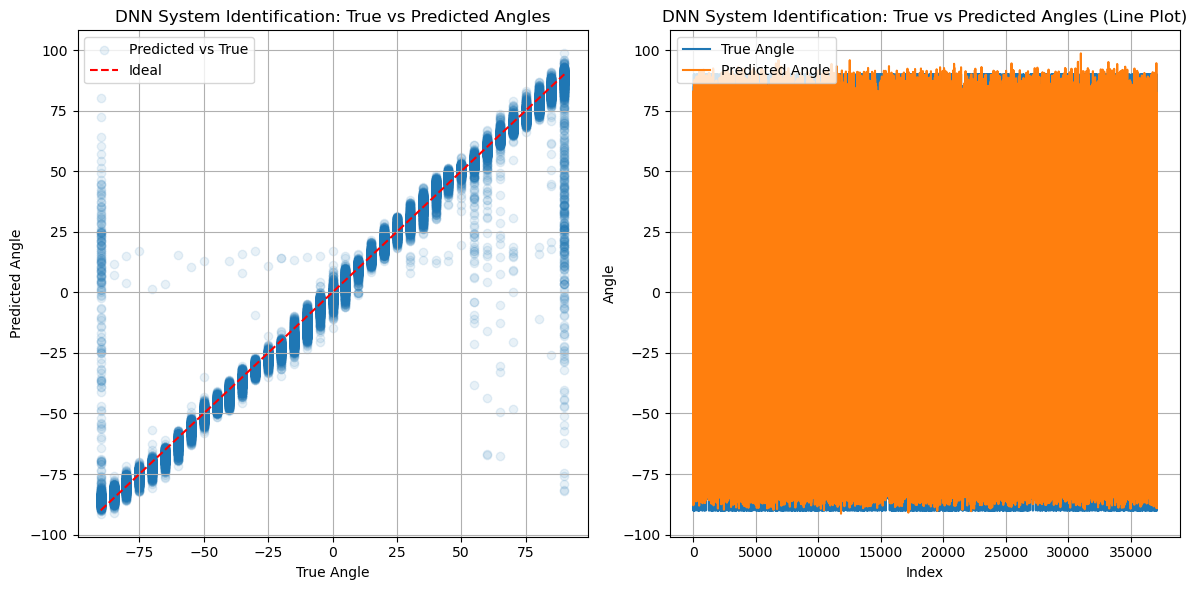

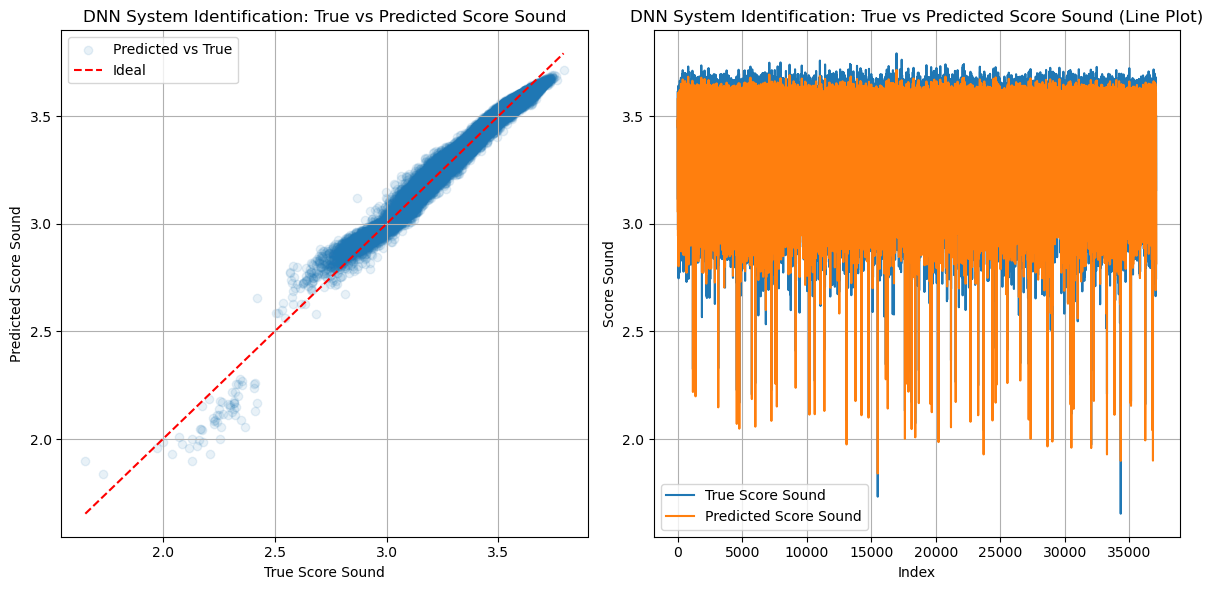

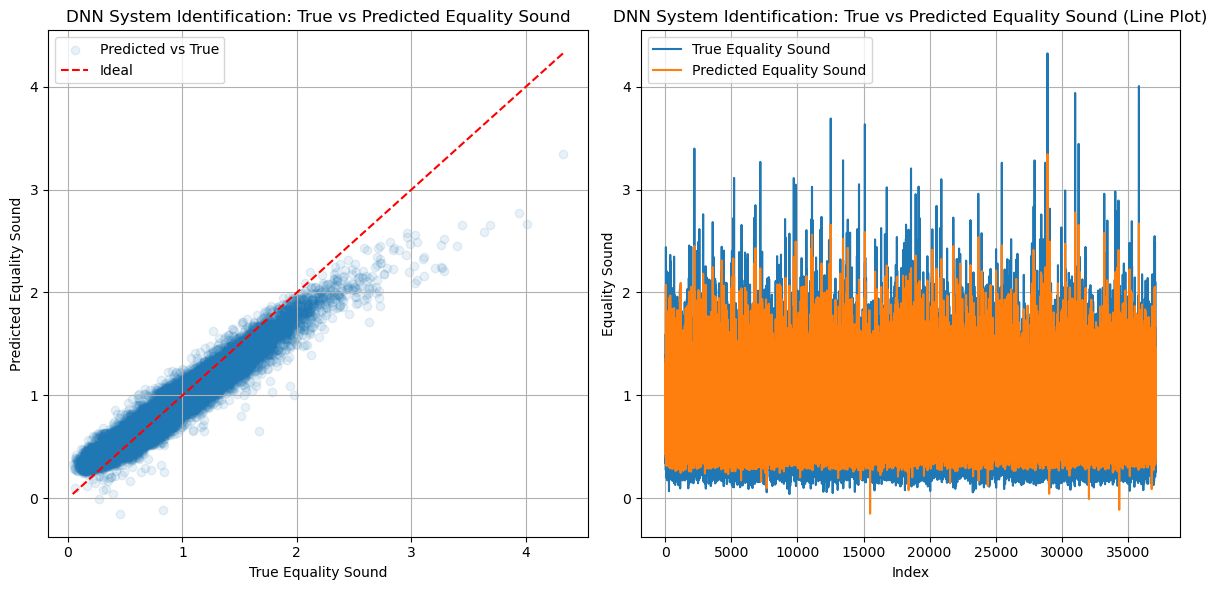

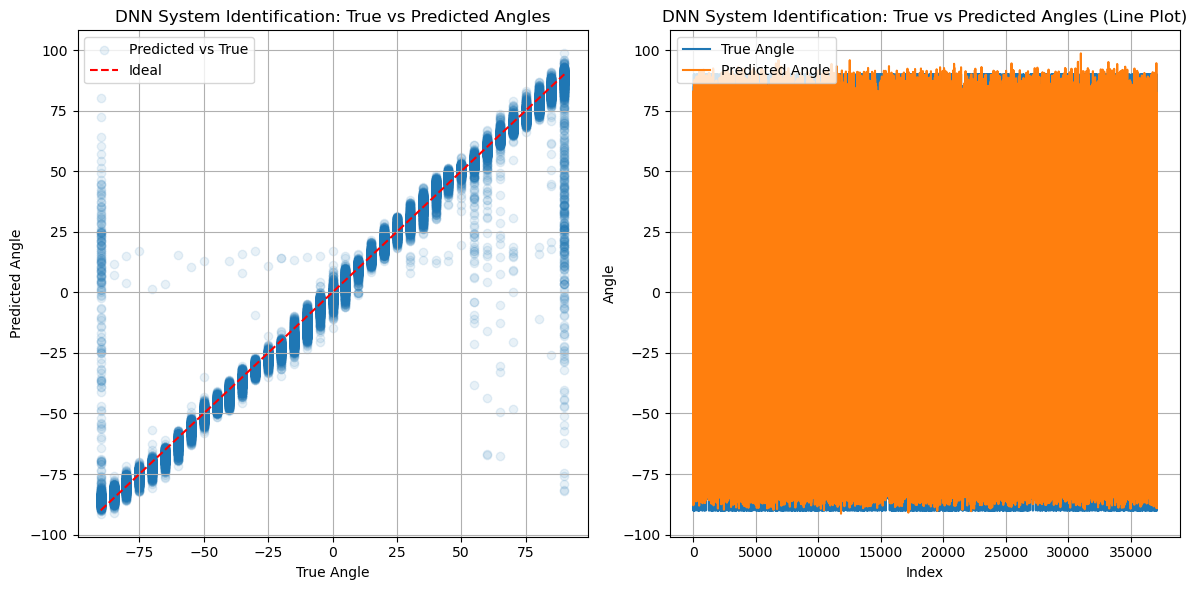

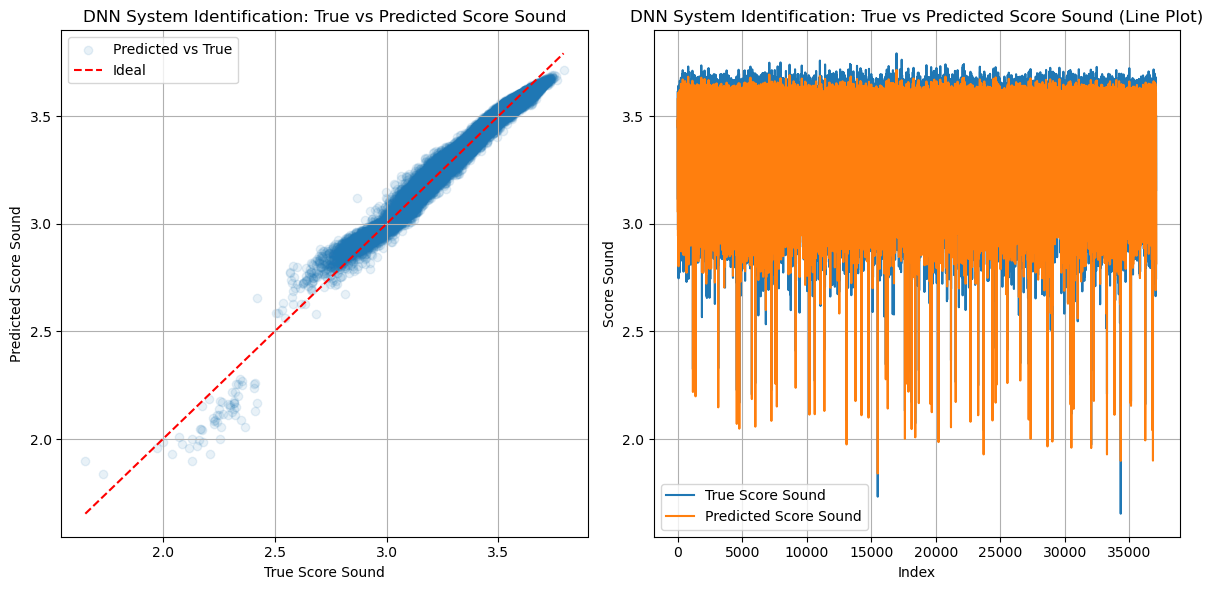

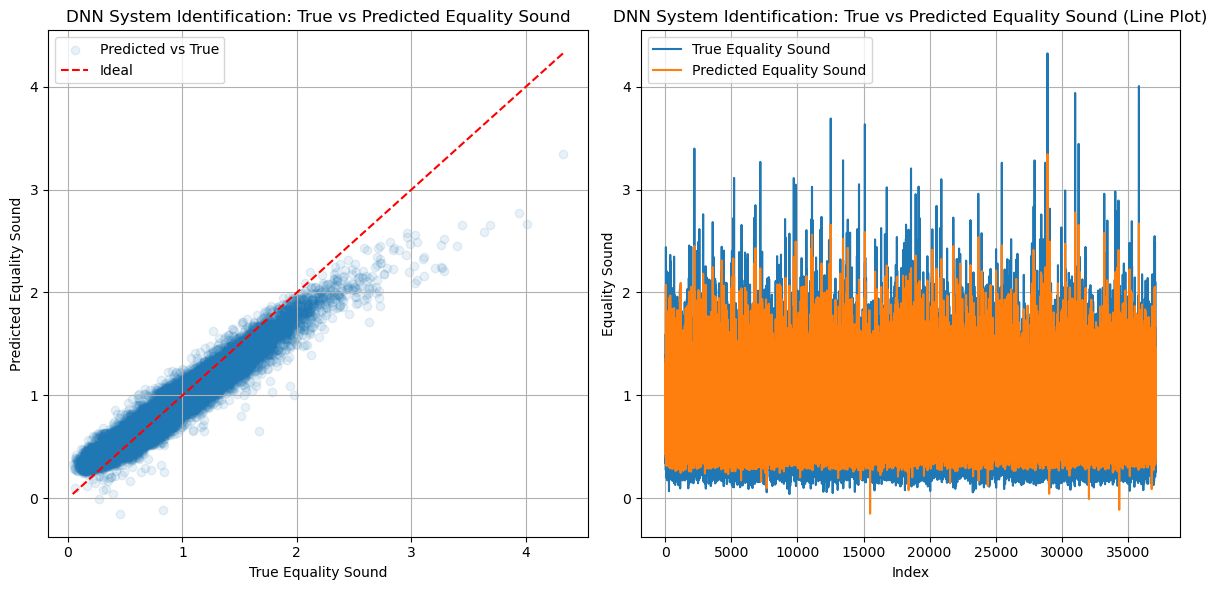

In [22]:
# Plot for Angle
plt.figure(figsize=(12, 6))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.1, label='Predicted vs True')
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], color='red', linestyle='--', label='Ideal')
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Angles")
plt.grid(True)

# Line plot
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 0], label='True Angle')
plt.plot(y_pred[:, 0], label='Predicted Angle')
plt.xlabel("Index")
plt.ylabel("Angle")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Angles (Line Plot)")
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot for Score Sound
plt.figure(figsize=(12, 6))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.1, label='Predicted vs True')
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], color='red', linestyle='--', label='Ideal')
plt.xlabel("True Score Sound")
plt.ylabel("Predicted Score Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Score Sound")
plt.grid(True)

# Line plot
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 1], label='True Score Sound')
plt.plot(y_pred[:, 1], label='Predicted Score Sound')
plt.xlabel("Index")
plt.ylabel("Score Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Score Sound (Line Plot)")
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot for Equality Sound
plt.figure(figsize=(12, 6))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 2], y_pred[:, 2], alpha=0.1, label='Predicted vs True')
plt.plot([min(y_test[:, 2]), max(y_test[:, 2])], [min(y_test[:, 2]), max(y_test[:, 2])], color='red', linestyle='--', label='Ideal')
plt.xlabel("True Equality Sound")
plt.ylabel("Predicted Equality Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Equality Sound")
plt.grid(True)

# Line plot
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 2], label='True Equality Sound')
plt.plot(y_pred[:, 2], label='Predicted Equality Sound')
plt.xlabel("Index")
plt.ylabel("Equality Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Equality Sound (Line Plot)")
plt.grid(True)

plt.tight_layout()
plt.show()
# Save the plots
plt.figure(figsize=(12, 6))

# Scatter plot for Angle
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.1, label='Predicted vs True')
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], color='red', linestyle='--', label='Ideal')
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Angles")
plt.grid(True)

# Line plot for Angle
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 0], label='True Angle')
plt.plot(y_pred[:, 0], label='Predicted Angle')
plt.xlabel("Index")
plt.ylabel("Angle")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Angles (Line Plot)")
plt.grid(True)

plt.tight_layout()
plt.savefig('angle_plots.png')
plt.show()

# Save the plots for Score Sound
plt.figure(figsize=(12, 6))

# Scatter plot for Score Sound
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.1, label='Predicted vs True')
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], color='red', linestyle='--', label='Ideal')
plt.xlabel("True Score Sound")
plt.ylabel("Predicted Score Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Score Sound")
plt.grid(True)

# Line plot for Score Sound
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 1], label='True Score Sound')
plt.plot(y_pred[:, 1], label='Predicted Score Sound')
plt.xlabel("Index")
plt.ylabel("Score Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Score Sound (Line Plot)")
plt.grid(True)

plt.tight_layout()
plt.savefig('score_sound_plots.png')
plt.show()

# Save the plots for Equality Sound
plt.figure(figsize=(12, 6))

# Scatter plot for Equality Sound
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 2], y_pred[:, 2], alpha=0.1, label='Predicted vs True')
plt.plot([min(y_test[:, 2]), max(y_test[:, 2])], [min(y_test[:, 2]), max(y_test[:, 2])], color='red', linestyle='--', label='Ideal')
plt.xlabel("True Equality Sound")
plt.ylabel("Predicted Equality Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Equality Sound")
plt.grid(True)

# Line plot for Equality Sound
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 2], label='True Equality Sound')
plt.plot(y_pred[:, 2], label='Predicted Equality Sound')
plt.xlabel("Index")
plt.ylabel("Equality Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Equality Sound (Line Plot)")
plt.grid(True)

plt.tight_layout()
plt.savefig('equality_sound_plots.png')
plt.show()

In [23]:
model.save("model_testing_dummy.h5")

In [24]:
model = load_model("model_testing_dummy.h5", custom_objects={"weighted_mse": weighted_mse})
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               12544     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [25]:
for layer in model.layers:
    print(f"Layer: {layer.name}")
    print(f"  Input shape: {layer.input_shape}")
    print(f"  Output shape: {layer.output_shape}")
    print(f"  Number of parameters: {layer.count_params()}")

Layer: dense
  Input shape: (None, 48)
  Output shape: (None, 256)
  Number of parameters: 12544
Layer: batch_normalization
  Input shape: (None, 256)
  Output shape: (None, 256)
  Number of parameters: 1024
Layer: leaky_re_lu
  Input shape: (None, 256)
  Output shape: (None, 256)
  Number of parameters: 0
Layer: dropout
  Input shape: (None, 256)
  Output shape: (None, 256)
  Number of parameters: 0
Layer: dense_1
  Input shape: (None, 256)
  Output shape: (None, 128)
  Number of parameters: 32896
Layer: batch_normalization_1
  Input shape: (None, 128)
  Output shape: (None, 128)
  Number of parameters: 512
Layer: leaky_re_lu_1
  Input shape: (None, 128)
  Output shape: (None, 128)
  Number of parameters: 0
Layer: dropout_1
  Input shape: (None, 128)
  Output shape: (None, 128)
  Number of parameters: 0
Layer: dense_2
  Input shape: (None, 128)
  Output shape: (None, 64)
  Number of parameters: 8256
Layer: batch_normalization_2
  Input shape: (None, 64)
  Output shape: (None, 64)
  Nu

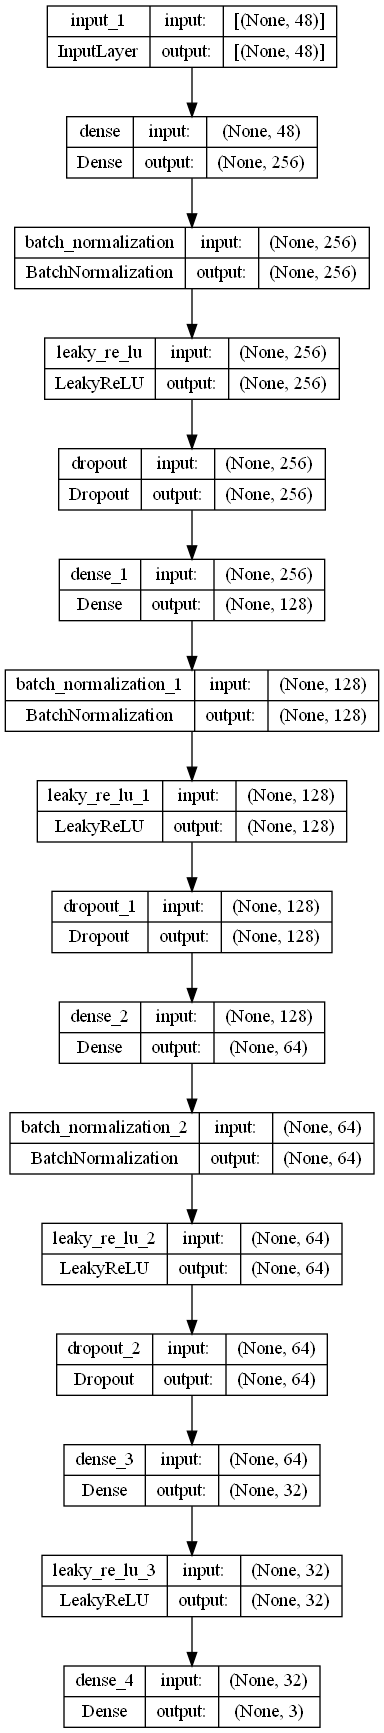

In [26]:
# Plot the model architecture to a file (e.g., PNG)
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [27]:
import tensorflow as tf
import keras as krs
import tensorflow.keras as keras
print("TensorFlow version:", tf.__version__)
print("Keras version (from tensorflow.keras):", keras.__version__)
print("Standalone Keras version:", krs.__version__)

TensorFlow version: 2.10.1
Keras version (from tensorflow.keras): 2.10.0
Standalone Keras version: 2.10.0


In [28]:
# Group by 'Angle' and calculate the mean for each group
average_features_per_angle = final_interpolated_df.groupby('Angle').mean()

average_features_per_angle.to_csv('full_features_data.csv')

# Display the result
average_features_per_angle

,Sensor1_CrestFactor,Sensor1_DominantFreq,Sensor1_DynamicRange,Sensor1_Kurtosis,Sensor1_Mean,Sensor1_SNR,Sensor1_SPL,Sensor1_Skewness,Sensor1_SpectralFlatness,Sensor1_StdDev,...,Sensor4_Mean,Sensor4_SNR,Sensor4_SPL,Sensor4_Skewness,Sensor4_SpectralFlatness,Sensor4_StdDev,Sensor4_THD,Sensor4_Variance,equality_sound,score_sound
Angle,,,,,,,,,,,,,,,,,,,,,
-90,1.201435,0.021553,5.480180,-0.787721,0.011401,124.892422,118.871822,0.008917,0.212676,1.653704,...,-0.022265,124.988165,118.967565,0.002351,0.211966,1.666343,6.669312,3.801779,1.274441,2.929663
-85,1.270861,0.073441,51.724211,-0.806283,0.000288,129.764291,123.743691,0.006323,0.295318,16.030255,...,-0.031280,129.831594,123.810994,0.001794,0.294773,16.042690,6.353615,58.094772,0.928492,3.111083
-80,1.326509,0.115147,97.650475,-0.821269,-0.006073,133.900714,127.880114,0.004275,0.361619,30.305740,...,-0.035749,133.945812,127.925212,0.001342,0.361207,30.316837,6.100710,770.791434,0.873682,3.251766
-75,1.369803,0.147720,142.947849,-0.833035,-0.008368,137.366805,131.346205,0.002711,0.413270,44.383738,...,-0.036397,137.395216,131.374616,0.000986,0.412962,44.392610,5.904090,2057.494840,0.854628,3.356283
-70,1.402170,0.172212,187.305212,-0.841937,-0.007280,140.227676,134.207076,0.001574,0.451958,58.167829,...,-0.033952,140.244203,134.223603,0.000713,0.451729,58.173839,5.757245,3833.808063,0.779016,3.429201
-65,1.425034,0.189674,230.411443,-0.848330,-0.003492,142.548439,136.527839,0.000803,0.479373,71.561591,...,-0.029139,142.557172,136.536572,0.000515,0.479200,71.564350,5.653666,6015.334177,0.652606,3.475090
-60,1.439822,0.201157,271.955420,-0.852571,0.002310,144.394207,138.373607,0.000339,0.497203,84.468605,...,-0.022686,144.398518,138.377918,0.000381,0.497068,84.467971,5.586845,8517.676257,0.526844,3.498520
-55,1.447956,0.207712,311.626022,-0.855014,0.009444,145.830093,139.809493,0.000123,0.507136,96.792448,...,-0.015319,145.832639,139.812039,0.000300,0.507026,96.788529,5.550273,11256.437378,0.459076,3.504058
-50,1.450864,0.210390,349.112125,-0.856017,0.017224,146.921209,140.900609,0.000097,0.510861,108.436702,...,-0.007764,146.923932,140.903332,0.000262,0.510764,108.429854,5.537441,14147.220612,0.485375,3.496275


In [29]:
feature_data.columns

Index(['Sensor1_Mean', 'Sensor1_Variance', 'Sensor1_StdDev',
       'Sensor1_Skewness', 'Sensor1_Kurtosis', 'Sensor1_CrestFactor',
       'Sensor1_DynamicRange', 'Sensor1_DominantFreq',
       'Sensor1_SpectralFlatness', 'Sensor1_THD', 'Sensor1_SNR', 'Sensor1_SPL',
       'Sensor2_Mean', 'Sensor2_Variance', 'Sensor2_StdDev',
       'Sensor2_Skewness', 'Sensor2_Kurtosis', 'Sensor2_CrestFactor',
       'Sensor2_DynamicRange', 'Sensor2_DominantFreq',
       'Sensor2_SpectralFlatness', 'Sensor2_THD', 'Sensor2_SNR', 'Sensor2_SPL',
       'Sensor3_Mean', 'Sensor3_Variance', 'Sensor3_StdDev',
       'Sensor3_Skewness', 'Sensor3_Kurtosis', 'Sensor3_CrestFactor',
       'Sensor3_DynamicRange', 'Sensor3_DominantFreq',
       'Sensor3_SpectralFlatness', 'Sensor3_THD', 'Sensor3_SNR', 'Sensor3_SPL',
       'Sensor4_Mean', 'Sensor4_Variance', 'Sensor4_StdDev',
       'Sensor4_Skewness', 'Sensor4_Kurtosis', 'Sensor4_CrestFactor',
       'Sensor4_DynamicRange', 'Sensor4_DominantFreq',
       'Sensor4_

In [30]:
# Make predictions
y_pred_full_norm = model.predict(X_norm)
y_pred_full = output_scaler.inverse_transform(y_pred_full_norm)

5794/5794 [==============================] - 13s 2ms/step


Shape of y: (185407, 3)
Shape of y_pred_full: (185407, 3)
Angle - Mean Absolute Error (MAE): 3.358627611423676
Angle - Mean Squared Error (MSE): 91.76939584470743
Angle - Root Mean Squared Error (RMSE): 9.579634431684093
Angle - R-squared (R²): 96.78002119843131%
Score Sound - Mean Absolute Error (MAE): 0.022270636979811236
Score Sound - Mean Squared Error (MSE): 0.0008549255188250942
Score Sound - Root Mean Squared Error (RMSE): 0.029239109405470854
Score Sound - R-squared (R²): 97.71503188951598%
Equality Sound - Mean Absolute Error (MAE): 0.08254464633919696
Equality Sound - Mean Squared Error (MSE): 0.012598485655512533
Equality Sound - Root Mean Squared Error (RMSE): 0.1122429759740561
Equality Sound - R-squared (R²): 91.9094615310232%


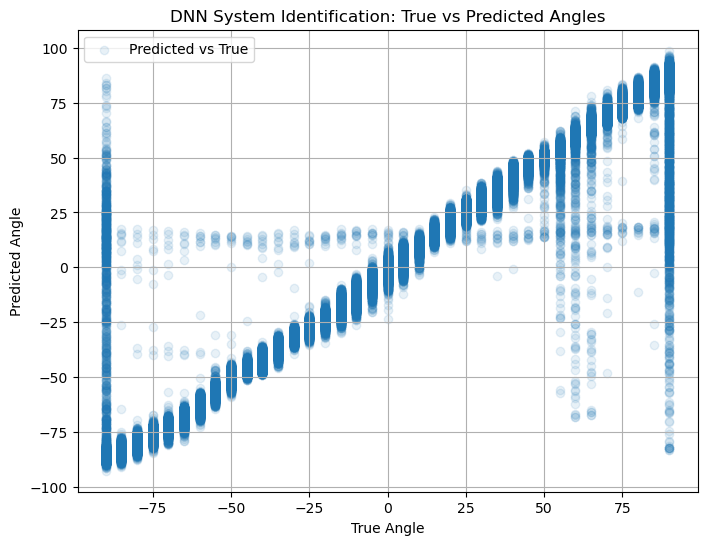

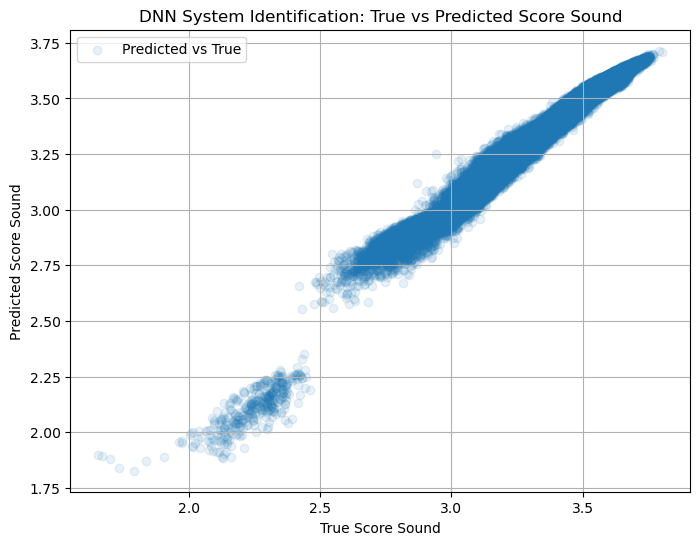

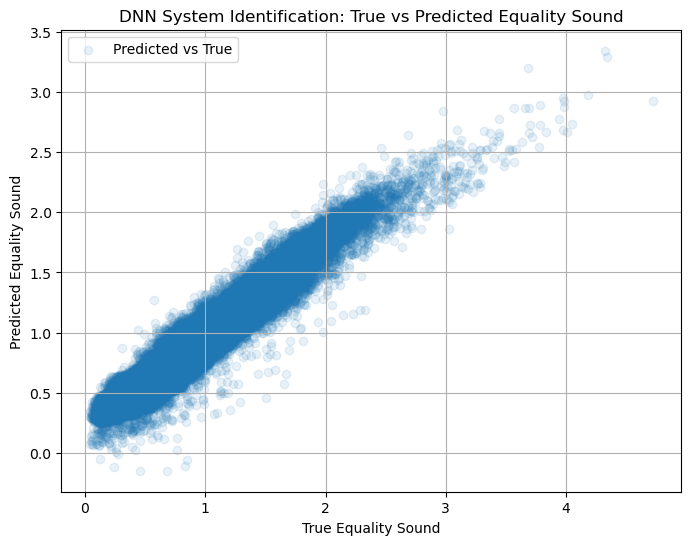

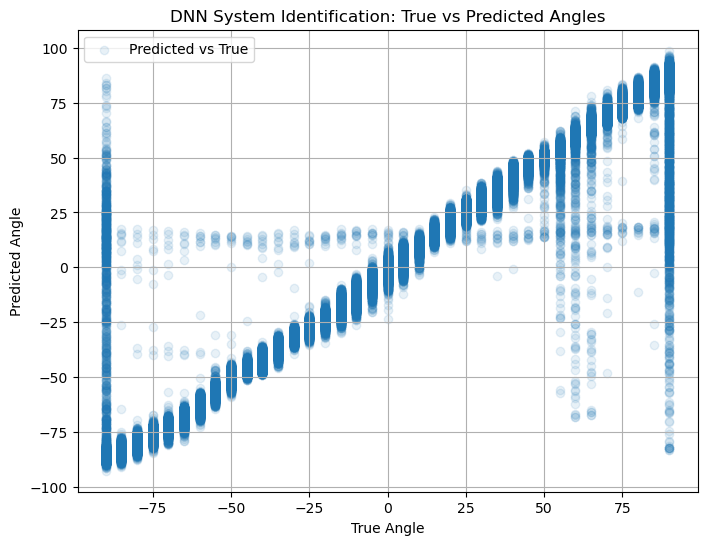

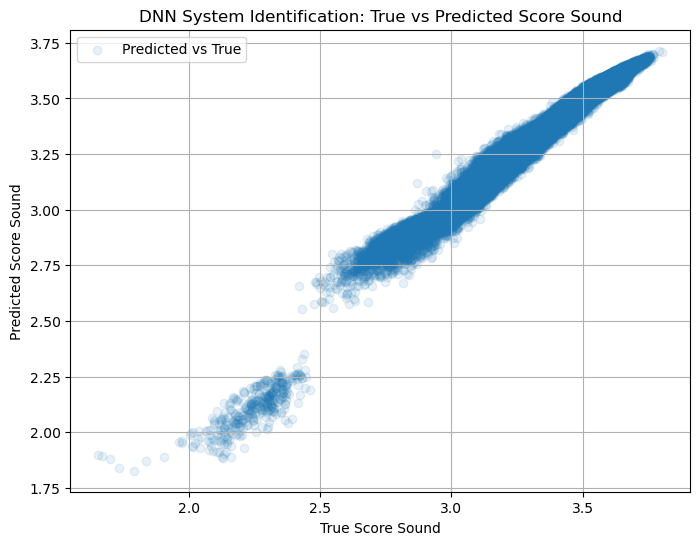

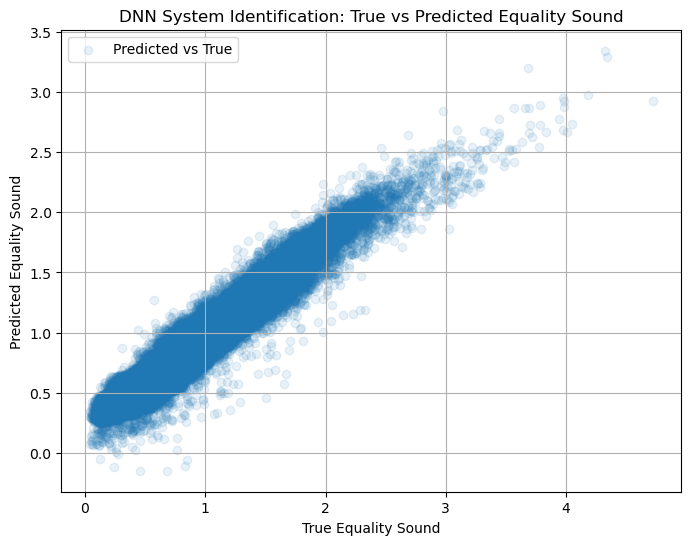

In [31]:
# Ensure y and y_pred_full have the same shape
print(f"Shape of y: {y.shape}")
print(f"Shape of y_pred_full: {y_pred_full.shape}")

# Calculate evaluation metrics on the original scale for each output
mae_angle = mean_absolute_error(y[:, 0], y_pred_full[:, 0])
mse_angle = mean_squared_error(y[:, 0], y_pred_full[:, 0])
rmse_angle = np.sqrt(mse_angle)
r2_angle = r2_score(y[:, 0], y_pred_full[:, 0]) * 100

mae_score_sound = mean_absolute_error(y[:, 1], y_pred_full[:, 1])
mse_score_sound = mean_squared_error(y[:, 1], y_pred_full[:, 1])
rmse_score_sound = np.sqrt(mse_score_sound)
r2_score_sound = r2_score(y[:, 1], y_pred_full[:, 1]) * 100

mae_equality_sound = mean_absolute_error(y[:, 2], y_pred_full[:, 2])
mse_equality_sound = mean_squared_error(y[:, 2], y_pred_full[:, 2])
rmse_equality_sound = np.sqrt(mse_equality_sound)
r2_equality_sound = r2_score(y[:, 2], y_pred_full[:, 2]) * 100

print(f"Angle - Mean Absolute Error (MAE): {mae_angle}")
print(f"Angle - Mean Squared Error (MSE): {mse_angle}")
print(f"Angle - Root Mean Squared Error (RMSE): {rmse_angle}")
print(f"Angle - R-squared (R²): {r2_angle}%")

print(f"Score Sound - Mean Absolute Error (MAE): {mae_score_sound}")
print(f"Score Sound - Mean Squared Error (MSE): {mse_score_sound}")
print(f"Score Sound - Root Mean Squared Error (RMSE): {rmse_score_sound}")
print(f"Score Sound - R-squared (R²): {r2_score_sound}%")

print(f"Equality Sound - Mean Absolute Error (MAE): {mae_equality_sound}")
print(f"Equality Sound - Mean Squared Error (MSE): {mse_equality_sound}")
print(f"Equality Sound - Root Mean Squared Error (RMSE): {rmse_equality_sound}")
print(f"Equality Sound - R-squared (R²): {r2_equality_sound}%")

# Plot for Angle
plt.figure(figsize=(8, 6))
plt.scatter(y[:, 0], y_pred_full[:, 0], alpha=0.1, label='Predicted vs True')
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Angles")
plt.grid(True)
plt.show()

# Plot for Score Sound
plt.figure(figsize=(8, 6))
plt.scatter(y[:, 1], y_pred_full[:, 1], alpha=0.1, label='Predicted vs True')
plt.xlabel("True Score Sound")
plt.ylabel("Predicted Score Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Score Sound")
plt.grid(True)
plt.show()

# Plot for Equality Sound
plt.figure(figsize=(8, 6))
plt.scatter(y[:, 2], y_pred_full[:, 2], alpha=0.1, label='Predicted vs True')
plt.xlabel("True Equality Sound")
plt.ylabel("Predicted Equality Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Equality Sound")
plt.grid(True)
plt.show()
# Save the plots
plt.figure(figsize=(8, 6))
plt.scatter(y[:, 0], y_pred_full[:, 0], alpha=0.1, label='Predicted vs True')
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Angles")
plt.grid(True)
plt.savefig('angle_true_vs_pred.png')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y[:, 1], y_pred_full[:, 1], alpha=0.1, label='Predicted vs True')
plt.xlabel("True Score Sound")
plt.ylabel("Predicted Score Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Score Sound")
plt.grid(True)
plt.savefig('score_sound_true_vs_pred.png')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y[:, 2], y_pred_full[:, 2], alpha=0.1, label='Predicted vs True')
plt.xlabel("True Equality Sound")
plt.ylabel("Predicted Equality Sound")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Equality Sound")
plt.grid(True)
plt.savefig('equality_sound_true_vs_pred.png')
plt.show()

# Save the metrics to a dictionary
metrics = {
    'Angle': {
        'MAE': mae_angle,
        'MSE': mse_angle,
        'RMSE': rmse_angle,
        'R2': r2_angle
    },
    'Score_Sound': {
        'MAE': mae_score_sound,
        'MSE': mse_score_sound,
        'RMSE': rmse_score_sound,
        'R2': r2_score_sound
    },
    'Equality_Sound': {
        'MAE': mae_equality_sound,
        'MSE': mse_equality_sound,
        'RMSE': rmse_equality_sound,
        'R2': r2_equality_sound
    }
}

# Save the metrics to a JSON file
with open('evaluation_metrics_full.json', 'w') as f:
    json.dump(metrics, f, indent=4)

In [32]:
# Convert y_pred_full to a pandas DataFrame
y_pred_df = pd.DataFrame(y_pred_full, columns=['Predicted_Angle', 'Predicted_Score_Sound', 'Predicted_Equality_Sound'])

# Concatenate y_pred_df with final_interpolated_df
final_interpolated_df_with_preds = pd.concat([final_interpolated_df.reset_index(drop=True), y_pred_df], axis=1)

# Group by 'Angle' and calculate the mean
grouped_df = final_interpolated_df_with_preds.groupby('Angle').mean().reset_index()

# Save the grouped_df dataframe to a CSV file
grouped_df.to_csv('grouped_data_with_predictions.csv', index=False)

grouped_df

,Angle,Sensor1_CrestFactor,Sensor1_DominantFreq,Sensor1_DynamicRange,Sensor1_Kurtosis,Sensor1_Mean,Sensor1_SNR,Sensor1_SPL,Sensor1_Skewness,Sensor1_SpectralFlatness,...,Sensor4_Skewness,Sensor4_SpectralFlatness,Sensor4_StdDev,Sensor4_THD,Sensor4_Variance,equality_sound,score_sound,Predicted_Angle,Predicted_Score_Sound,Predicted_Equality_Sound
0,-90,1.201435,0.021553,5.480180,-0.787721,0.011401,124.892422,118.871822,0.008917,0.212676,...,0.002351,0.211966,1.666343,6.669312,3.801779,1.274441,2.929663,-71.179283,2.947773,1.213557
1,-85,1.270861,0.073441,51.724211,-0.806283,0.000288,129.764291,123.743691,0.006323,0.295318,...,0.001794,0.294773,16.042690,6.353615,58.094772,0.928492,3.111083,-83.252205,3.112160,0.911784
2,-80,1.326509,0.115147,97.650475,-0.821269,-0.006073,133.900714,127.880114,0.004275,0.361619,...,0.001342,0.361207,30.316837,6.100710,770.791434,0.873682,3.251766,-79.535400,3.260466,0.836599
3,-75,1.369803,0.147720,142.947849,-0.833035,-0.008368,137.366805,131.346205,0.002711,0.413270,...,0.000986,0.412962,44.392610,5.904090,2057.494840,0.854628,3.356283,-75.495323,3.354901,0.819890
4,-70,1.402170,0.172212,187.305212,-0.841937,-0.007280,140.227676,134.207076,0.001574,0.451958,...,0.000713,0.451729,58.173839,5.757245,3833.808063,0.779016,3.429201,-71.875839,3.418058,0.762987
5,-65,1.425034,0.189674,230.411443,-0.848330,-0.003492,142.548439,136.527839,0.000803,0.479373,...,0.000515,0.479200,71.564350,5.653666,6015.334177,0.652606,3.475090,-67.900772,3.459200,0.664051
6,-60,1.439822,0.201157,271.955420,-0.852571,0.002310,144.394207,138.373607,0.000339,0.497203,...,0.000381,0.497068,84.467971,5.586845,8517.676257,0.526844,3.498520,-62.493721,3.485772,0.557793
7,-55,1.447956,0.207712,311.626022,-0.855014,0.009444,145.830093,139.809493,0.000123,0.507136,...,0.000300,0.507026,96.788529,5.550273,11256.437378,0.459076,3.504058,-56.239948,3.494558,0.490380
8,-50,1.450864,0.210390,349.112125,-0.856017,0.017224,146.921209,140.900609,0.000097,0.510861,...,0.000262,0.510764,108.429854,5.537441,14147.220612,0.485375,3.496275,-50.207783,3.488533,0.496417
9,-45,1.449971,0.210242,384.102611,-0.855934,0.024969,147.732668,141.712068,0.000199,0.510067,...,0.000256,0.509975,119.295771,5.541839,17105.629035,0.605974,3.479739,-46.413551,3.469160,0.591622


In [33]:
from pyswarm import pso

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for PSO
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because PSO minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle as lists
angle_bounds = ([final_interpolated_df['Angle'].min()], [final_interpolated_df['Angle'].max()])

# Run PSO
optimal_angle, optimal_score = pso(objective_function, angle_bounds[0], angle_bounds[1], args=(model, features_mean, scaler))

print(f"Optimal Angle (PSO): {optimal_angle}")

1/1 [==============================] - 0s 22ms/step
Stopping search: maximum iterations reached --> 100
Optimal Angle (PSO): [-60.26791131]


In [34]:
from scipy.optimize import minimize

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for L-BFGS-B
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because L-BFGS-B minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run L-BFGS-B
result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), bounds=angle_bounds, method='L-BFGS-B')

optimal_angle = result.x[0]
print(f"Optimal Angle (L-BFGS-B): {optimal_angle}")

1/1 [==============================] - 0s 23ms/step
Optimal Angle (L-BFGS-B): 0.0


In [35]:
# Assuming final_interpolated_df_with_preds is already defined and contains the predictions

# Group by 'Angle' and calculate the mean
grouped_df = final_interpolated_df_with_preds.groupby('Angle').mean().reset_index()

# Define the optimization criteria
# For example, you can use a weighted sum of score_sound and equality_sound
weights = {'score_sound': 1, 'equality_sound': -2}  # Adjust weights as needed

# Calculate the optimization score
grouped_df['Optimization_Score'] = (
    weights['score_sound'] * grouped_df['Predicted_Score_Sound'] +
    weights['equality_sound'] * grouped_df['Predicted_Equality_Sound']
)

# Find the angle with the highest optimization score
optimal_angle = grouped_df.loc[grouped_df['Optimization_Score'].idxmax(), 'Angle']

print(f"Optimal Angle (Grouped DataFrame): {optimal_angle}")

Optimal Angle (Grouped DataFrame): 55


In [36]:
from scipy.optimize import dual_annealing

# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for Simulated Annealing
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because Simulated Annealing minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run Simulated Annealing
result = dual_annealing(objective_function, bounds=angle_bounds, args=(model, features_mean, scaler))

optimal_angle = result.x[0]
print(f"Optimal Angle (Simulated Annealing): {optimal_angle}")

1/1 [==============================] - 0s 28ms/step
Optimal Angle (Simulated Annealing): -5.439216187720902


In [37]:
from scipy.optimize import differential_evolution

# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for Differential Evolution
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because Differential Evolution minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run Differential Evolution
result = differential_evolution(objective_function, bounds=angle_bounds, args=(model, features_mean, scaler))

optimal_angle = result.x[0]
print(f"Optimal Angle (Differential Evolution): {optimal_angle}")

1/1 [==============================] - 0s 18ms/step
Optimal Angle (Differential Evolution): 47.22417986830671


In [38]:
from skopt import gp_minimize
from skopt.space import Real

# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for Bayesian Optimization
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because Bayesian Optimization minimizes the objective function
    return -optimization_score[0]  # Ensure it returns a scalar

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [Real(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run Bayesian Optimization
result = gp_minimize(lambda x: objective_function(x[0], model, features_mean, scaler), dimensions=angle_bounds, n_calls=50, random_state=42)

optimal_angle = result.x[0]
print(f"Optimal Angle (Bayesian Optimization): {optimal_angle}")

1/1 [==============================] - 0s 4ms/step
Optimal Angle (Bayesian Optimization): 53.377737634841964


In [39]:
# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for COBYLA
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because COBYLA minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run COBYLA
result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='COBYLA', bounds=angle_bounds)

optimal_angle = result.x[0]
print(f"Optimal Angle (COBYLA): {optimal_angle}")

1/1 [==============================] - 0s 29ms/step
Optimal Angle (COBYLA): 0.0


In [40]:
# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for Nelder-Mead
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because Nelder-Mead minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run Nelder-Mead
result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='Nelder-Mead', bounds=angle_bounds)

optimal_angle = result.x[0]
print(f"Optimal Angle (Nelder-Mead): {optimal_angle}")

1/1 [==============================] - 0s 28ms/step
Optimal Angle (Nelder-Mead): 0.0


In [41]:
from scipy.optimize import basinhopping, minimize

# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for Basin-Hopping
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because Basin-Hopping minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Define the local optimizer
local_optimizer = {
    'method': 'L-BFGS-B',
    'bounds': angle_bounds,
    'args': (model, features_mean, scaler)
}

# Run Basin-Hopping
result = basinhopping(objective_function, x0=[final_interpolated_df['Angle'].mean()], minimizer_kwargs=local_optimizer, niter=100, stepsize=0.5)

optimal_angle = result.x[0]
print(f"Optimal Angle (Basin-Hopping): {optimal_angle}")

1/1 [==============================] - 0s 27ms/step
Optimal Angle (Basin-Hopping): 0.0


In [42]:
from scipy.optimize import minimize

# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for Gradient Descent
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because Gradient Descent minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run Gradient Descent (Conjugate Gradient)
result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='CG', bounds=angle_bounds)

optimal_angle = result.x[0]
print(f"Optimal Angle (Gradient Descent - CG): {optimal_angle}")

1/1 [==============================] - 0s 21ms/step
Optimal Angle (Gradient Descent - CG): 0.0


C:\Users\Acer\AppData\Local\Temp\ipykernel_24852\2255957770.py:39: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='CG', bounds=angle_bounds)


In [43]:
# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for TNC
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because TNC minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run TNC
result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='TNC', bounds=angle_bounds)

optimal_angle = result.x[0]
print(f"Optimal Angle (TNC): {optimal_angle}")

1/1 [==============================] - 0s 17ms/step
Optimal Angle (TNC): 0.0


In [44]:
# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for Powell's Method
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because Powell's Method minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run Powell's Method
result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='Powell', bounds=angle_bounds)

optimal_angle = result.x[0]
print(f"Optimal Angle (Powell's Method): {optimal_angle}")

1/1 [==============================] - 0s 20ms/step
Optimal Angle (Powell's Method): 89.99994020626843


In [45]:
# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for SLSQP
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because SLSQP minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run SLSQP
result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='SLSQP', bounds=angle_bounds)

optimal_angle = result.x[0]
print(f"Optimal Angle (SLSQP): {optimal_angle}")

1/1 [==============================] - 0s 26ms/step
Optimal Angle (SLSQP): 0.0


In [46]:
# Assuming final_interpolated_df is already defined and contains the data

# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for Conjugate Gradient
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because Conjugate Gradient minimizes the objective function
    return -optimization_score

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run Conjugate Gradient
result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='CG', bounds=angle_bounds)

optimal_angle = result.x[0]
print(f"Optimal Angle (Conjugate Gradient): {optimal_angle}")

1/1 [==============================] - 0s 12ms/step
Optimal Angle (Conjugate Gradient): 0.0


C:\Users\Acer\AppData\Local\Temp\ipykernel_24852\2466092911.py:37: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='CG', bounds=angle_bounds)


In [47]:
# Define the scaler and fit it on the training data
scaler = MinMaxScaler()
X_train = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).values
scaler.fit(X_train)

# Define the objective function for Newton's Method
def objective_function(angle, model, features_mean, scaler):
    # Create a DataFrame with the angle and other features
    features = features_mean.copy()
    features['Angle'] = angle
    
    # Normalize the features (excluding the Angle column)
    features_norm = scaler.transform(features.drop(columns=['Angle']).values)
    
    # Predict outcomes using the model
    predictions = model.predict(features_norm)
    
    # Extract predicted score_sound and equality_sound
    predicted_score_sound = predictions[:, 1]
    predicted_equality_sound = predictions[:, 2]
    
    # Define the optimization criteria (maximize score_sound and minimize equality_sound)
    optimization_score = predicted_score_sound - 2 * predicted_equality_sound
    
    # Return the negative optimization score because Newton's Method minimizes the objective function
    return -optimization_score

# Define the Jacobian (gradient) of the objective function using finite differences
def jacobian(angle, model, features_mean, scaler, epsilon=1e-8):
    angle = np.array(angle)
    grad = np.zeros_like(angle)
    
    for i in range(len(angle)):
        angle_plus = angle.copy()
        angle_minus = angle.copy()
        angle_plus[i] += epsilon
        angle_minus[i] -= epsilon
        
        f_plus = objective_function(angle_plus, model, features_mean, scaler)
        f_minus = objective_function(angle_minus, model, features_mean, scaler)
        
        grad[i] = (f_plus - f_minus) / (2 * epsilon)
    
    return grad

# Generate the mean features
features_mean = final_interpolated_df.drop(columns=['Angle', 'score_sound', 'equality_sound']).mean().to_frame().T

# Define the bounds for the angle
angle_bounds = [(final_interpolated_df['Angle'].min(), final_interpolated_df['Angle'].max())]

# Run Newton's Method
result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='Newton-CG', jac=jacobian, bounds=angle_bounds)

optimal_angle = result.x[0]
print(f"Optimal Angle (Newton's Method): {optimal_angle}")

1/1 [==============================] - ETA: 0s

C:\Users\Acer\AppData\Local\Temp\ipykernel_24852\2112144657.py:53: RuntimeWarning: Method Newton-CG cannot handle bounds.
  result = minimize(objective_function, x0=[final_interpolated_df['Angle'].mean()], args=(model, features_mean, scaler), method='Newton-CG', jac=jacobian, bounds=angle_bounds)


1/1 [==============================] - 0s 23ms/step
Optimal Angle (Newton's Method): 0.0


C:\Users\Acer\AppData\Local\Temp\ipykernel_24852\2112144657.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (f_plus - f_minus) / (2 * epsilon)
